ML ШИФТ

[JINT] (SHIFT-64009) Пашина Алёна

270 балла

# Описание задачи

Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить 'таблетку'. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить, кому конкретно принадлежит 'след' прохода через турникеты? Мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько новых - не больше 10%).

'8 утра понедельник, турникет 4? Директор.' '11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.'  Какие есть паттерны в настоящих данных?

**Цель** - предсказать, кто вошел в здание по времени и турникету.

**Описание данных**

В обучающей выборке:

* `user_id` - ID посетителя
* `ts` - дата и время прохождения через турникет
* `gate_id` - ID турникета

В тестовой выборке `user_id` заменены на слова: `aucroc, binary, blue, categorical` и т.п.

Требуется составить таблицу вида:

| user_word | preds |
| --- | --- |
| aucroc | 50 |
| binary | 11 |
| blue | -999 |
| ... | ... |

* `user_word` - закодированные ID пользователей
* `preds` - предсказанные ID
* `-999` - ID нового посетителя, которого раньше не было

Таблицу нужно запомнить как `csv` и потом заархивировать в `zip` архив. 

Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать ID. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее отгадали слово, тем больше баллов.

Посетителей здания будем считать сотрудниками некой компании.

# Импорт библиотек

In [343]:
import pandas as pd
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (roc_auc_score, 
                             f1_score,
                             roc_curve, 
                             accuracy_score, 
                             ConfusionMatrixDisplay, 
                             confusion_matrix, 
                             recall_score,
                             precision_score)
from sklearn.inspection import permutation_importance
from catboost import (CatBoostClassifier,
                        Pool,
                        EShapCalcType,
                        EFeaturesSelectionAlgorithm)

import shap
import loguru
import plotly
import phik
import zipfile
import io
import re
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution

In [344]:
# sklearn.set_config(transform_output="pandas")
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

RANDOM_STATE = 42

In [345]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# Первичный анализ и предобработка данных

In [346]:
df_train = pd.read_csv('../data/train.csv', index_col=[0], parse_dates=[2])
df_test = pd.read_csv('../data/test.csv', index_col=[0], parse_dates=[1])
ex_submit = pd.read_csv('../data/submit.csv')

In [347]:
for name, df in zip(['тренировочная выборка', 'тестовая выборка', 'пример решения'], [df_train, df_test, ex_submit]):
    print(f'\033[1m{name}:\033[0m')
    display(df)
    print(f'\033[1mобщая информация - {name}:\033[0m')
    df.info()
    print(f'\033[1mколичество пропусков: {df.isna().sum().sum()}\033[0m')
    print(f'\033[1mколичество явных дубликатов: {df.duplicated().sum()}\033[0m')
    print()

тренировочная выборка:


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


общая информация - тренировочная выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB
количество пропусков: 0
количество явных дубликатов: 2346

тестовая выборка:


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


общая информация - тестовая выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 222.7+ KB
количество пропусков: 0
количество явных дубликатов: 505

пример решения:


,user_word,preds
0,aucroc,49
1,binary,12
2,blue,55
3,categorical,14
4,coefficient,15
5,collinear,12
6,distributed,12
7,epsilon,1
8,f1,37
9,fit,3


общая информация - пример решения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_word  34 non-null     object
 1   preds      34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes
количество пропусков: 0
количество явных дубликатов: 0



Пропусков в данных не обнаружено.

В тренировочной и тестовой выборке есть явные дубликаты, пока не будем удалять их. Проанализируем позже.

In [348]:
# df_train = df_train.drop_duplicates().reset_index(drop=True)
# df_test = df_test.drop_duplicates().reset_index(drop=True)

In [349]:
df_train.shape

(37518, 3)

In [350]:
df_test.shape

(7125, 3)

In [351]:
df_train.ts.agg([min, max]).to_frame()

,ts
min,2022-07-29 09:08:54
max,2022-12-31 20:39:31


In [352]:
df_test.ts.agg([min, max]).to_frame()

,ts
min,2023-01-03 08:21:00
max,2023-02-24 19:44:09


In [353]:
(df_test.ts.max() - df_train.ts.min()).days // 30

7

Предоставлены данные за 7 месяцев - с июля 2022 по фефраль 2023. Номер месяца в качестве признака не подойдет.

ID сотрудников

In [354]:
# id сотрудников в train
print(*sorted(df_train.user_id.unique()), sep=', ')
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57
Количество сотрудников в train: 56


In [355]:
# отсутствующие id
set(range(0, 58)) - set(df_train.user_id.unique())

{13, 16}

In [356]:
# активность сотрудников в train
count_user_id = df_train.user_id.value_counts(ascending=True).to_frame()

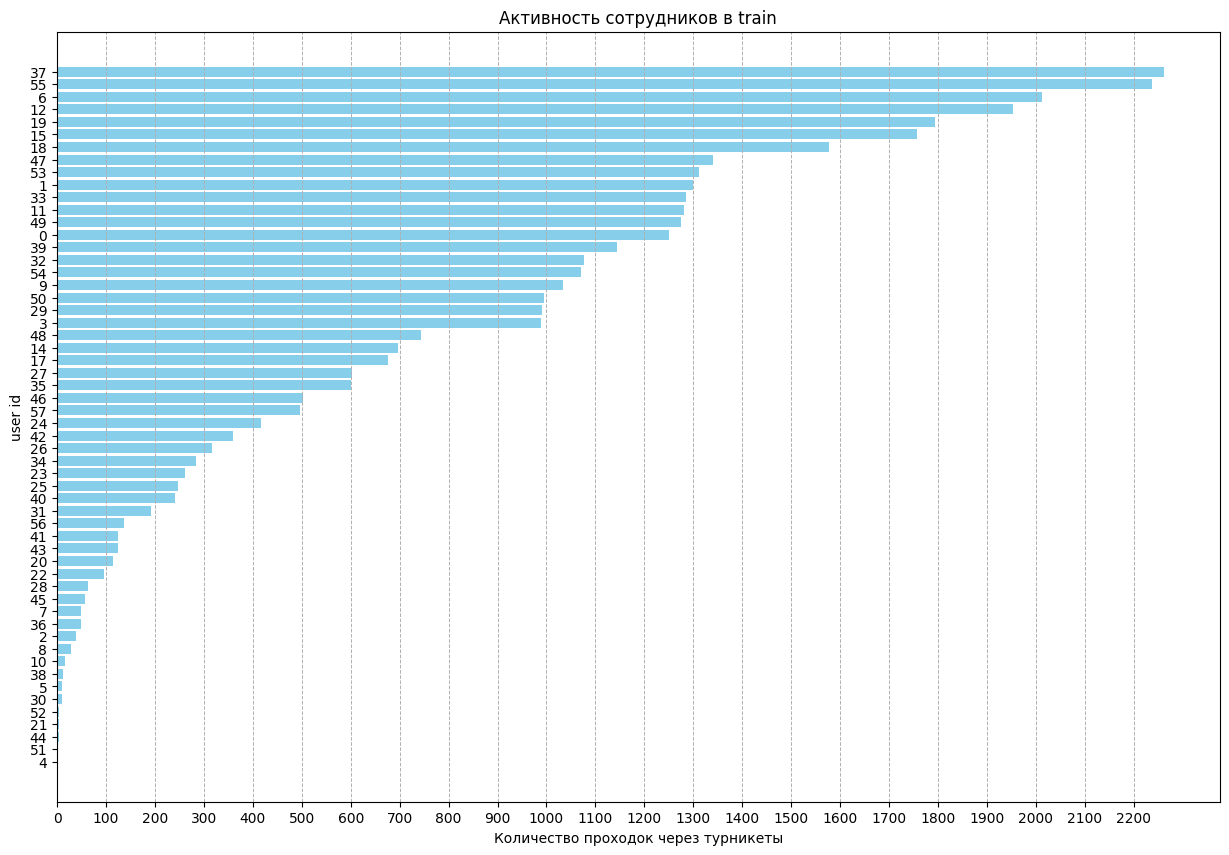

In [357]:
plt.figure(figsize=(15, 10))
plt.barh(count_user_id.index.astype(str), count_user_id['count'], color='skyblue')
plt.xlabel('Количество проходок через турникеты')
plt.ylabel('user id')
plt.title('Активность сотрудников в train')
plt.xticks(np.arange(0, 2210, 100))
plt.grid(axis='x', linestyle='--', linewidth=0.7)

Удалим неактивных сотрудников, количество проходов через турникеты которых менее 30. Поскольку это слишком маленькие категории для обучения (подбор гиперпараметров модели будет выполняться с помощью кроссвалидации), и, скорее всего, этих сотрудников нет в test.

In [358]:
delete_user_id = count_user_id[count_user_id['count'] < 30].index.to_list()
delete_user_id

[4, 51, 44, 21, 52, 30, 5, 38, 10, 8]

In [359]:
df_train = df_train[~df_train['user_id'].isin(delete_user_id)]
df_train.shape

(37420, 3)

In [360]:
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

Количество сотрудников в train: 46


In [361]:
print(f'Количество сотрудников в test: {len(df_test.user_word.unique())}')

Количество сотрудников в test: 34


In [362]:
# по условию сказано, что в тестовой выборке может быть не более 10% новых сотрудников
int(.1 * len(df_test.user_word.unique()))

3

In [363]:
# активность сотрудников в test
count_user_word = df_test.user_word.value_counts(ascending=True).to_frame()

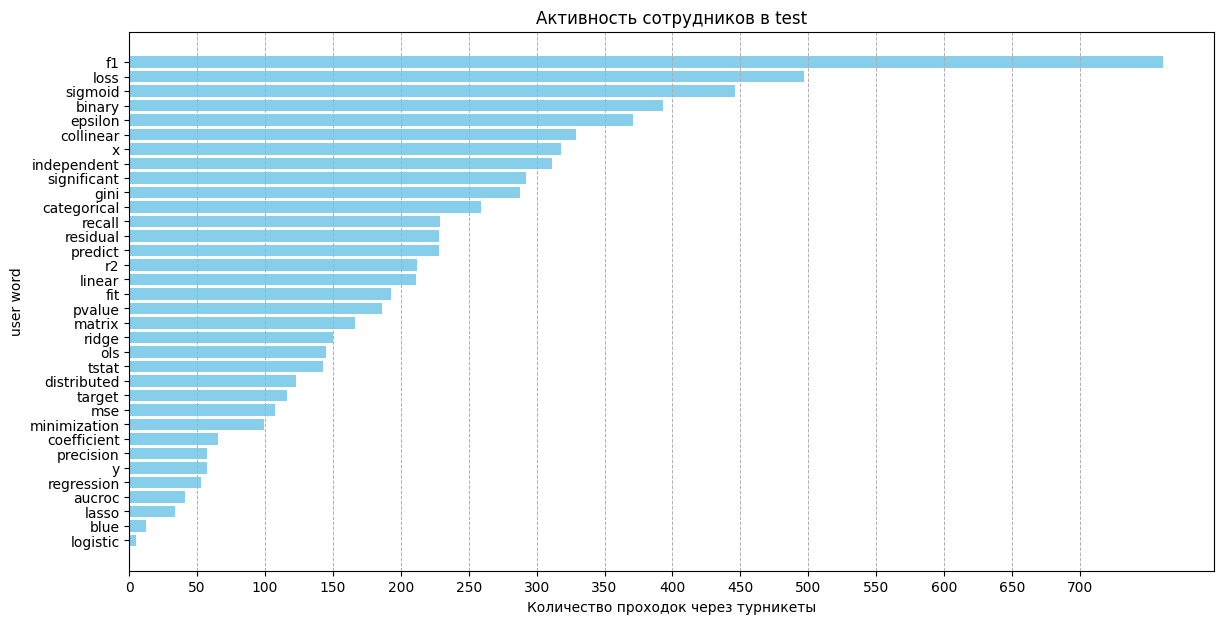

In [364]:
plt.figure(figsize=(14, 7))
plt.barh(count_user_word.index.astype(str), count_user_word['count'], color='skyblue')
plt.xlabel('Количество проходок через турникеты')
plt.ylabel('user word')
plt.title('Активность сотрудников в test')
plt.xticks(np.arange(0, 750, 50))
plt.grid(axis='x', linestyle='--', linewidth=0.7)

Турникеты

In [365]:
print(f'Количество турникетов в train: {len(df_train.gate_id.unique())}')
# частота использования турникетов в train
count_gate_id_train = df_train.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_train.T

Количество турникетов в train: 17


gate_id,14,0,16,1,8,-1,15,12,13,6,7,9,11,5,10,3,4
count,1,2,3,5,46,48,298,698,1201,1796,3022,3384,4081,4599,4757,5337,8142


In [366]:
print(f'Количество турникетов в test: {len(df_test.gate_id.unique())}')
# частота использования турникетов в test
count_gate_id_test = df_test.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_test.T

Количество турникетов в test: 16


gate_id,14,1,-1,2,8,15,12,6,13,7,11,9,5,3,10,4
count,1,2,2,4,18,102,132,294,345,540,762,780,860,909,915,1459


In [367]:
# id турникетов, которые есть в train, но нет в test
set(df_train.gate_id.unique()) - set(df_test.gate_id.unique())

{0, 16}

In [368]:
# id турникетов, которые есть в test, но нет в train
set(df_test.gate_id.unique()) - set(df_train.gate_id.unique())

{2}

Поскольку `gate_id` мы будем использовать в качестве признака, редкие категории (менее 5 записей) нужно удалить.

In [369]:
delete_gate_id = set(count_gate_id_train.query('count < 5').index) | set(count_gate_id_test.query('count < 5').index)
delete_gate_id

{-1, 0, 1, 2, 14, 16}

In [370]:
df_train = df_train.query('gate_id not in @delete_gate_id').reset_index(drop=True)
df_test = df_test.query('gate_id not in @delete_gate_id').reset_index(drop=True)

In [371]:
df_test.shape

(7116, 3)

Двойное срабатывание турникетов

In [372]:
def make_features_for_analysis(df):
    df = df.loc[:]
    # отсортируем датафреймы для удобства генерирования признаков
    df.sort_values(['user_id', 'ts'], inplace=True)
    df['date'] = df.ts.dt.normalize()
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # предыдущий турникет
    df['gate_id_lag_1'] = grouped_data['gate_id'].shift(1, fill_value=-100)
    # разница в секундах между текущей записью и предыдущей
    df['sec_btw_lag_1'] = df['total_seconds'] - grouped_data['total_seconds'].shift(1)
    df['sec_btw_lag_1'] = df['sec_btw_lag_1'].fillna(-1000).astype('int')

    return df

In [373]:
def plot_count_sec_btw_repeating_gate_id(df, max_interval_sec=100):
    # отфильтруем данные с повторным срабатыванием турникета
    df_repeating_gate_id = df.query('gate_id == gate_id_lag_1')
    # частота наблюдаемых промежутков времени между повторными срабатываниями турникетов
    sec_btw_repeating_gate_id = df_repeating_gate_id['sec_btw_lag_1'].value_counts().to_frame().sort_index()
    sec_btw_repeating_gate_id = sec_btw_repeating_gate_id[sec_btw_repeating_gate_id.index < max_interval_sec]

    plt.figure(figsize=(15, 3))
    plt.bar(sec_btw_repeating_gate_id.index.astype(str), sec_btw_repeating_gate_id['count'], color='skyblue')
    plt.xlabel('Количество секунд между повторными срабатываниями турникетов')
    plt.ylabel('Количество повторных срабатываний')
    plt.title('Повторное срабатывание турникетов');

In [374]:
def check_repeating_gate_id(df):
    # отфильтруем данные с повторным срабатыванием турникета
    df_repeating_gate_id = df.query('gate_id == gate_id_lag_1')
    result = pd.concat(
        [
            # умножаем на 2 для визуального сравнения с общим количеством срабатываний
            df_repeating_gate_id.query('sec_btw_lag_1 <= 3')['gate_id'].value_counts() * 2,
            df['gate_id'].value_counts()
        ],
        axis=1
    ).reset_index().fillna(0).astype(int)
    result.columns = ['gate_id', 'repeating', 'total']
    display(result)

In [375]:
df_train = make_features_for_analysis(df_train)

# временно переименуем колонку `user_word` на `user_id`
df_test = df_test.rename(columns={'user_word': 'user_id'})
df_test = make_features_for_analysis(df_test)

,gate_id,repeating,total
0,4,8110,8142
1,3,5276,5337
2,5,4592,4599
3,9,3384,3384
4,6,1792,1796
5,13,1196,1201
6,12,698,698
7,8,46,46
8,7,4,3022
9,10,0,4757


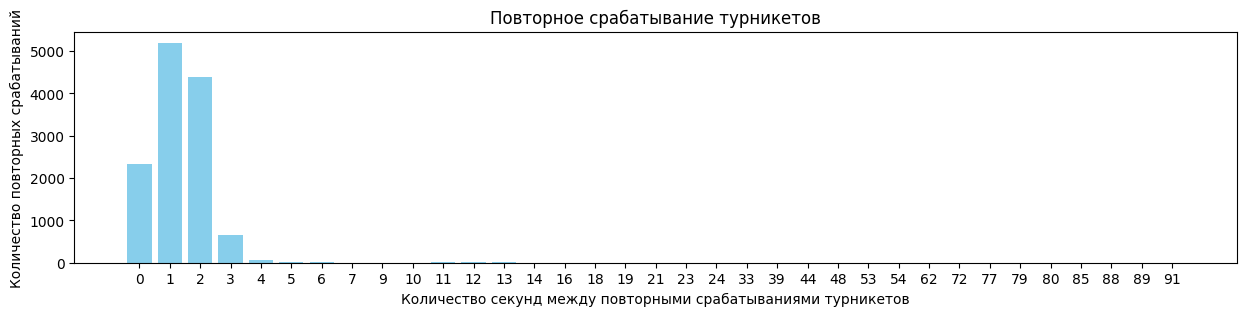

In [376]:
plot_count_sec_btw_repeating_gate_id(df_train)
check_repeating_gate_id(df_train)

,gate_id,repeating,total
0,4,1442,1459
1,3,888,909
2,5,834,860
3,9,780,780
4,13,344,345
5,6,292,294
6,12,132,132
7,8,18,18
8,7,2,540
9,10,0,915


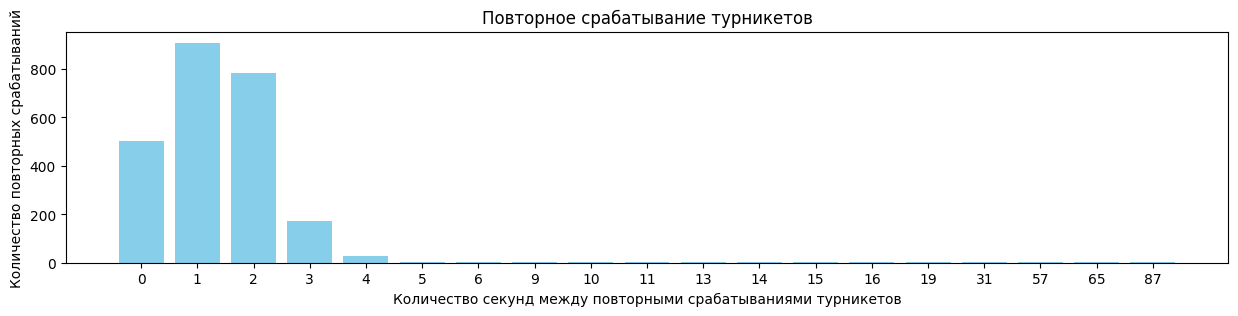

In [377]:
plot_count_sec_btw_repeating_gate_id(df_test)
check_repeating_gate_id(df_test)

Исходя из данных выше, полными дубликатами можно считать записи, если одновременно выполняются условия:

- `gate_id` совпадает с предыдущим,
- промежуток времени между срабатываниями не превышает 3 секунд,
- `gate_id` не равен 7.

In [378]:
df_train = df_train.query('not (gate_id == gate_id_lag_1 and sec_btw_lag_1 <= 3 and gate_id != 7)')
df_train.shape

(24814, 9)

In [379]:
df_test = df_test.query('not (gate_id == gate_id_lag_1 and sec_btw_lag_1 <= 3 and gate_id != 7)')
df_test.shape

(4751, 9)

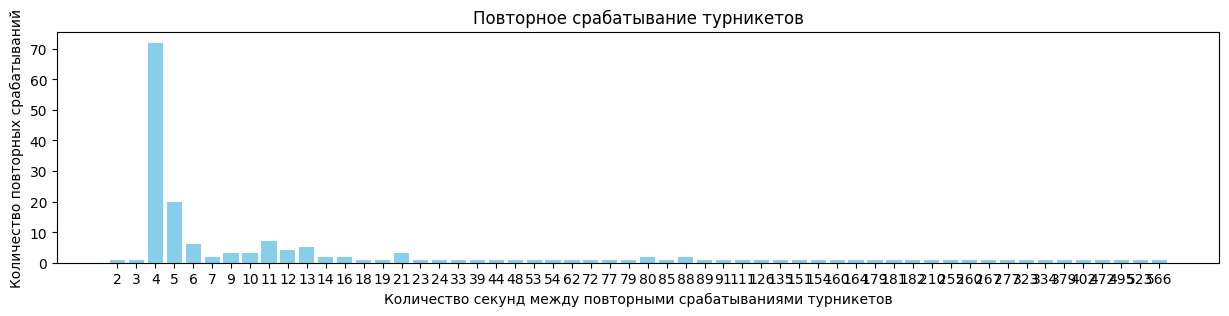

In [380]:
plot_count_sec_btw_repeating_gate_id(df_train, max_interval_sec=60*10)

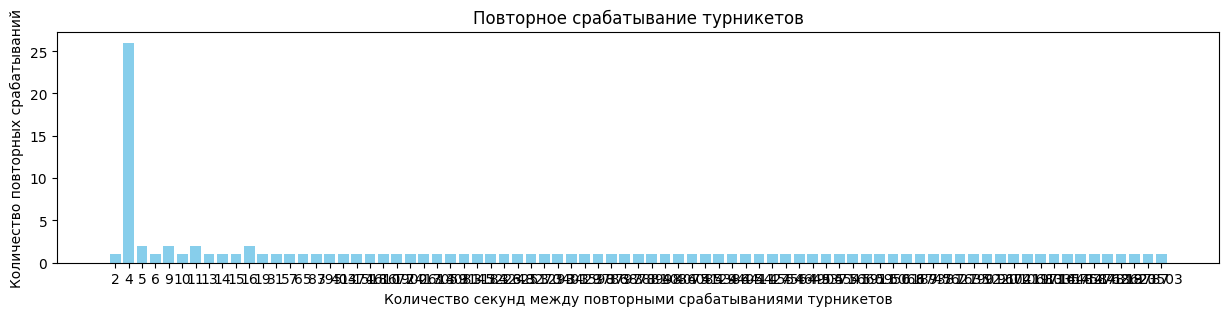

In [381]:
plot_count_sec_btw_repeating_gate_id(df_test, max_interval_sec=60*1000000)

# Генерирование признаков

In [382]:
def make_features(df):
    df = df.loc[:]
    # отсортируем датафрейм для удобства генерирования признаков
    # потом отсортируем только по дате
    df = df.sort_values(['user_id', 'ts']).reset_index(drop=True)
    # временные признаки
    df['date'] = df.ts.dt.normalize()
    df['day_of_month'] = df.ts.dt.day
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    df['week_number'] = df.ts.dt.isocalendar().week             # неделя начинается с пн. Вспомогательный признак
    df['day_of_week'] = df.ts.dt.dayofweek                      # 0 = пн.
    df['is_weekend'] = df.day_of_week >= 5
    df['time_of_day'] = np.select(
            condlist=[df['hour'] < 6, df['hour'] < 12, df['hour'] < 18],
            choicelist=['night', 'morning', 'afternoon'],
            default='evening',
    )       # время суток
    df['is_month_start'] = df['ts'].dt.is_month_start
    df['is_month_end'] = df['ts'].dt.is_month_end

    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # число проходов сотрудником ч/з турникуты в день
    df['pass_cnt_per_day'] = grouped_data['gate_id'].transform('size')
    # число проходов через конкретный турникет в конкретный день
    df['daily_gate_pass_count'] = df.groupby(['user_id', 'date', 'gate_id'])['gate_id'].transform('size')
    # вероятность прохода через конкретный турникет в конкретный день
    df['probability_gate_id'] = df['daily_gate_pass_count'] / df['pass_cnt_per_day']
    # количество сотрудников, вошедших в конкретный день в здание
    df['cnt_users_per_day'] = df.groupby('date')['user_id'].transform('nunique')
    # количество сотрудников, вошедших в конкретную неделю в здание
    df['cnt_users_per_week'] = df.groupby('week_number')['user_id'].transform('nunique')
    # индекс дневной явки сотрудника
    df['daily_attendance_index'] = df['cnt_users_per_day'] / df['cnt_users_per_week']
    # количество дней в конкретную неделю, в которые сотрудник заходил в здание
    df['cnt_days_per_week'] = df.groupby(['user_id', 'week_number'])['date'].transform('nunique')

    # время прихода на работу (количество минут от полуночи)
    df['entry_time'] = grouped_data['ts'].transform('min')
    df['entry_time'] = ((df['entry_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # время ухода с работы (количество минут от полуночи)
    df['exit_time'] = grouped_data['ts'].transform('max')
    df['exit_time'] = ((df['exit_time'] - df['date']).dt.total_seconds() // 60).astype('int')   # Вспомогательный признак
    # продолжительность рабочего времени в минутах
    df['working_time_per_day'] = df['exit_time'] - df['entry_time']
    # турникет, через который сотрудник зашел в здание в конкретный день
    df['entrance_gate_id'] = grouped_data['gate_id'].transform('first')
    # турникет, через который сотрудник вышел из здания в конкретный день
    df['exit_gate_id'] = grouped_data['gate_id'].transform('last')
    # продолжительность рабочего времени за неделю в минутах (working_time_per_week)
    df_working_time_per_week = df.groupby(['user_id', 'date'], as_index=False)[['week_number', 'working_time_per_day']].first()
    df_working_time_per_week = df_working_time_per_week.groupby(['user_id', 'week_number'], as_index=False)[['working_time_per_day']].sum()
    df_working_time_per_week = df_working_time_per_week.rename(columns={'working_time_per_day': 'working_time_per_week'})
    df = pd.merge(df, df_working_time_per_week, on=['user_id', 'week_number'], how='left')
    # индекс дневной нагрузки сотрудника - отношение минут работы за день к минутам работы за неделю
    df['daily_workload_index'] = df['working_time_per_day'] / df['working_time_per_week']
    # на случай, когда working_time_per_day = 0 и working_time_per_week = 0
    df['daily_workload_index'] = df['daily_workload_index'].fillna(0)

    for i in range(1, 6):
        # 5 предыдущих турникетов
        df[f'gate_id_lag_{i}'] = grouped_data['gate_id'].shift(i, fill_value=-100)
        # 5 последующих турникетов
        df[f'gate_id_{i}'] = grouped_data['gate_id'].shift(-i, fill_value=-200)
        # разница в секундах между текущей записью и пятью предыдущими
        df[f'sec_btw_lag_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(i)
        df[f'sec_btw_lag_{i}'] = df[f'sec_btw_lag_{i}'].fillna(-1000).astype('int')
        # разница в секундах между текущей записью и пятью следующими
        df[f'sec_btw_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(-i)
        df[f'sec_btw_{i}'] = df[f'sec_btw_{i}'].fillna(1000).astype('int')

    # метка gate_id, совпадающего с предыдущим, промежуток между срабатываниями менее 5 секунд
    df['repeat_gate_lt_5s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].lt(5)
    # -//- от 5 до 10 секунд
    df['repeat_gate_btw_5_10s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].between(5, 10, inclusive='left')
    # -//- от 10 до 15 секунд
    df['repeat_gate_btw_10_15s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].between(10, 15, inclusive='left')
    # -//- от 15 до 90 секунд
    df['repeat_gate_btw_15_90s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].between(15, 90, inclusive='left')
    # -//- от 90 секунд
    df['repeat_gate_ge_90s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].ge(90)
    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # количество повторных срабатываний турникетов для user_id в конкретный день, промежуток между срабатываниями менее 5 секунд
    df['cnt_repeat_gate_lt_5s'] = grouped_data['repeat_gate_lt_5s'].transform('sum')
    # -//- от 5 до 10 секунд
    df['cnt_repeat_gate_btw_5_10s'] = grouped_data['repeat_gate_btw_5_10s'].transform('sum')
    # -//- от 10 до 15 секунд
    df['cnt_repeat_gate_btw_10_15s'] = grouped_data['repeat_gate_btw_10_15s'].transform('sum')
    # -//- от 15 до 90 секунд
    df['cnt_repeat_gate_btw_15_90s'] = grouped_data['repeat_gate_btw_15_90s'].transform('sum')
    # -//- от 90 секунд
    df['cnt_repeat_gate_ge_90s'] = grouped_data['repeat_gate_ge_90s'].transform('sum')

    # маршрут – содержит информацию о соседних турникетах, через которые прошел сотрудник (направление не учитывается)
    df['route'] = df.apply(lambda row: str(sorted([row['gate_id_lag_1'], row['gate_id']])), axis=1)
    # если сотрудник пришел с улицы
    df.loc[df['route'].str.contains('-100'), 'route'] = 'not_route'

    # вспомогательный признак
    df['temp_sec_btw_lag_1'] = df['sec_btw_lag_1']
    # если сотрудник пришел с улицы
    df.loc[df['temp_sec_btw_lag_1'] < 0, 'temp_sec_btw_lag_1'] = 0
    # накопленное время нахождения в здании к моменту прохода через турникет в течение дня
    df['cumtime_per_day'] = df.groupby(['user_id', 'date'])['temp_sec_btw_lag_1'].cumsum()
    # накопленное время нахождения на конкретном маршруте в течение дня
    df['cumtime_at_route_per_day'] = df.groupby(['user_id', 'date', 'route'])['temp_sec_btw_lag_1'].cumsum()

    # самый часто используемый турникет за день
    df['most_frequent_gate_per_day'] = df.groupby(['user_id', 'date'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет за неделю
    df['most_frequent_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за день
    df['most_frequent_route_per_day'] = df.groupby(['user_id', 'date'])['route'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за неделю
    df['most_frequent_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform(lambda x: x.value_counts().idxmax())

    # удаление вспомогательных признаков
    # df = df.drop(columns=['week_number', 'exit_time', 'temp_sec_btw_lag_1'])

    return df

In [383]:
df_train = make_features(df_train)
df_train.head(3)

,user_id,ts,gate_id,date,hour,total_minutes,total_seconds,gate_id_lag_1,sec_btw_lag_1,day_of_month,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_lt_5s,repeat_gate_btw_5_10s,repeat_gate_btw_10_15s,repeat_gate_btw_15_90s,repeat_gate_ge_90s,cnt_repeat_gate_lt_5s,cnt_repeat_gate_btw_5_10s,cnt_repeat_gate_btw_10_15s,cnt_repeat_gate_btw_15_90s,cnt_repeat_gate_ge_90s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week
0,0,2022-07-29 10:30:17,3,2022-07-29,10,630,37817,-100,-1000,29,30,4,False,morning,False,False,8,2,0.25,23,23,1.00,1,630,1126,496,3,4,496,1.00,11,-10144,-100,6,-1000,-10171,-100,7,-1000,-13798,-100,3,-1000,-13869,-100,10,-1000,-13899,False,False,False,False,False,0,0,0,0,0,not_route,0,0,0,3,3,not_route,not_route
1,0,2022-07-29 13:19:21,11,2022-07-29,13,799,47961,3,10144,29,30,4,False,afternoon,False,False,8,2,0.25,23,23,1.00,1,630,1126,496,3,4,496,1.00,6,-27,-100,7,-1000,-3654,-100,3,-1000,-3725,-100,10,-1000,-3755,-100,11,-1000,-19588,False,False,False,False,False,0,0,0,0,0,"[3, 11]",10144,10144,10144,3,3,not_route,not_route
2,0,2022-07-29 13:19:48,6,2022-07-29,13,799,47988,11,27,29,30,4,False,afternoon,False,False,8,1,0.12,23,23,1.00,1,630,1126,496,3,4,496,1.00,7,-3627,3,3,10171,-3698,-100,10,-1000,-3728,-100,11,-1000,-19561,-100,4,-1000,-19589,False,False,False,False,False,0,0,0,0,0,"[6, 11]",27,10171,27,3,3,not_route,not_route


In [384]:
df_train.shape

(24814, 66)

In [385]:
df_test = make_features(df_test)
# df_test = df_test.rename(columns={'user_id': 'user_word'})
df_test.head(3)

,ts,gate_id,user_id,date,hour,total_minutes,total_seconds,gate_id_lag_1,sec_btw_lag_1,day_of_month,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_lt_5s,repeat_gate_btw_5_10s,repeat_gate_btw_10_15s,repeat_gate_btw_15_90s,repeat_gate_ge_90s,cnt_repeat_gate_lt_5s,cnt_repeat_gate_btw_5_10s,cnt_repeat_gate_btw_10_15s,cnt_repeat_gate_btw_15_90s,cnt_repeat_gate_ge_90s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week
0,2023-01-04 11:07:00,15,aucroc,2023-01-04,11,667,40020,-100,-1000,4,1,2,False,morning,False,False,7,2,0.29,21,27,0.78,2,667,1103,436,15,15,632,0.69,9,-164,-100,5,-1000,-174,-100,10,-1000,-192,-100,11,-1000,-25885,-100,4,-1000,-25910,False,False,False,False,False,0,0,0,0,0,not_route,0,0,0,15,15,not_route,not_route
1,2023-01-04 11:09:44,9,aucroc,2023-01-04,11,669,40184,15,164,4,1,2,False,morning,False,False,7,1,0.14,21,27,0.78,2,667,1103,436,15,15,632,0.69,5,-10,-100,10,-1000,-28,-100,11,-1000,-25721,-100,4,-1000,-25746,-100,15,-1000,-26000,False,False,False,False,False,0,0,0,0,0,"[9, 15]",164,164,164,15,15,not_route,not_route
2,2023-01-04 11:09:54,5,aucroc,2023-01-04,11,669,40194,9,10,4,1,2,False,morning,False,False,7,1,0.14,21,27,0.78,2,667,1103,436,15,15,632,0.69,10,-18,15,11,174,-25711,-100,4,-1000,-25736,-100,15,-1000,-25990,-100,-200,-1000,1000,False,False,False,False,False,0,0,0,0,0,"[5, 9]",10,174,10,15,15,not_route,not_route


In [386]:
df_test.shape

(4751, 66)

In [387]:
df_train['route'].value_counts()

route
[10, 11]     3427
[4, 11]      3310
not_route    2503
[3, 10]      2250
[5, 10]      1809
[3, 7]       1712
[5, 9]        996
[4, 7]        957
[4, 9]        667
[5, 7]        655
[7, 9]        625
[6, 11]       550
[10, 13]      519
[4, 5]        500
[3, 4]        490
[4, 10]       474
[12, 13]      381
[10, 10]      352
[5, 11]       273
[3, 11]       252
[6, 10]       241
[3, 6]        214
[6, 7]        207
[6, 9]        192
[9, 15]       145
[11, 12]      142
[5, 6]        126
[4, 15]       104
[11, 13]       87
[10, 12]       84
[11, 11]       59
[13, 13]       55
[4, 12]        38
[3, 13]        37
[4, 4]         35
[5, 13]        34
[3, 15]        33
[5, 5]         31
[7, 7]         25
[3, 9]         23
[4, 13]        22
[3, 3]         22
[4, 8]         16
[6, 13]        16
[15, 15]       16
[12, 12]       15
[5, 15]        13
[6, 12]        11
[3, 8]          9
[5, 12]         8
[5, 8]          8
[6, 6]          8
[3, 5]          7
[7, 15]         7
[7, 8]          5
[9, 

In [388]:
df_train.groupby('route')['temp_sec_btw_lag_1'].sum().sort_values(ascending=False)/3600

route
[10, 11]    10,891.64
[4, 10]      1,345.32
[5, 11]        832.22
[3, 11]        729.90
[6, 10]        713.69
[4, 7]         649.87
[10, 13]       570.95
[10, 10]       523.34
[4, 5]         434.09
[3, 4]         417.36
[12, 13]       188.58
[10, 12]       147.72
[3, 6]         147.48
[6, 7]         130.95
[11, 12]       127.54
[11, 13]       125.27
[5, 6]         125.13
[13, 13]        79.41
[5, 10]         65.19
[4, 12]         57.27
[3, 13]         53.93
[5, 13]         45.36
[11, 11]        42.58
[3, 10]         42.12
[4, 11]         30.58
[3, 7]          29.46
[7, 9]          26.26
[4, 13]         24.66
[15, 15]        19.97
[12, 12]        15.12
[6, 13]         14.72
[6, 12]         14.63
[5, 7]          12.31
[6, 11]         11.77
[9, 15]         10.67
[4, 15]          7.03
[7, 15]          6.48
[5, 9]           5.60
[3, 12]          5.11
[4, 9]           4.83
[7, 7]           3.88
[3, 15]          3.05
[9, 9]           2.96
[5, 12]          2.19
[5, 15]          2.13
[3, 

In [389]:
df_train.isna().sum().sum()

0

In [390]:
df_test.isna().sum().sum()

0

# Исследовательский анализ данных

In [391]:
week_counts_train = df_train['week_number'].value_counts().sort_index().reset_index()

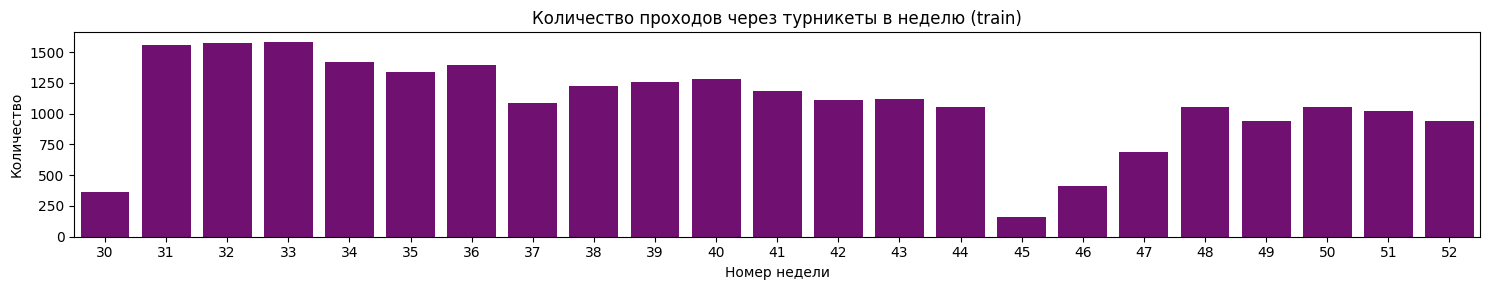

In [392]:
plt.figure(figsize=(15, 3))
sns.barplot(x='week_number', y='count', data=week_counts_train, color='purple')
plt.title('Количество проходов через турникеты в неделю (train)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [393]:
df_train.loc[df_train['week_number'] == 30, 'date'].nunique()

3

In [394]:
df_train.loc[df_train['week_number'] == 45, 'date'].nunique()

3

Мы видим, что 30 неделя - неполная. Поскольку при генерировании признаков мы использовали агрегацию по номеру недели, удалим данные за 30 неделю из тренировочной выборки.

In [395]:
df_train.shape

(24814, 66)

In [396]:
df_train = df_train.query('week_number > 30 and week_number != 45').reset_index(drop=True)
df_train.shape

(24288, 66)

In [397]:
df_train['user_id'].nunique()

46

In [398]:
week_counts_test = df_test['week_number'].value_counts().sort_index().reset_index()

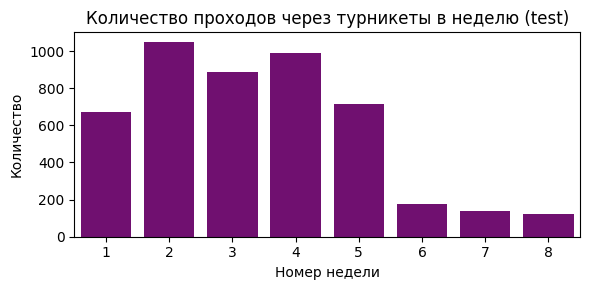

In [399]:
plt.figure(figsize=(6, 3))
sns.barplot(x='week_number', y='count', data=week_counts_test, color='purple')
plt.title('Количество проходов через турникеты в неделю (test)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [400]:
df_test.loc[df_test['week_number'] == 1, 'date'].nunique()

5

In [401]:
df_test.loc[df_test['week_number'] == 8, 'date'].nunique()

5

Удалим из тестовой выборки данные с 6 по 8 неделю, поскольку в этот период была маленькая активность.

In [402]:
df_test.shape

(4751, 66)

In [403]:
df_test = df_test.query('week_number < 6').reset_index(drop=True)
df_test.shape

(4315, 66)

In [404]:
df_test['user_id'].nunique()

34

In [405]:
# посмотрим распределение классов зависимой переменной
df_train['user_id'].value_counts(normalize=True)

user_id
37   0.06
55   0.06
12   0.05
6    0.05
15   0.05
19   0.05
18   0.04
47   0.04
1    0.04
33   0.03
11   0.03
0    0.03
49   0.03
53   0.03
9    0.03
39   0.03
32   0.03
54   0.03
50   0.03
3    0.03
29   0.03
48   0.02
14   0.02
17   0.02
35   0.02
57   0.01
27   0.01
46   0.01
24   0.01
42   0.01
26   0.01
34   0.01
40   0.01
23   0.01
25   0.01
31   0.00
43   0.00
41   0.00
56   0.00
20   0.00
22   0.00
28   0.00
45   0.00
7    0.00
36   0.00
2    0.00
Name: proportion, dtype: float64

In [406]:
df_train['user_id'].value_counts()

user_id
37    1509
55    1480
12    1303
6     1280
15    1144
19    1140
18     901
47     877
1      851
33     837
11     832
0      824
49     818
53     808
9      767
39     747
32     737
54     693
50     658
3      643
29     634
48     490
14     467
17     453
35     399
57     338
27     315
46     294
24     274
42     244
26     193
34     187
40     170
23     170
25     151
31     120
43      81
41      80
56      74
20      72
22      61
28      46
45      39
7       33
36      27
2       27
Name: count, dtype: int64

In [407]:
df_test['user_id'].value_counts(normalize=True)

user_id
f1             0.11
loss           0.07
sigmoid        0.07
binary         0.05
epsilon        0.05
significant    0.04
collinear      0.04
x              0.04
independent    0.04
residual       0.04
linear         0.03
gini           0.03
fit            0.03
predict        0.03
pvalue         0.03
recall         0.03
r2             0.03
categorical    0.03
ridge          0.02
tstat          0.02
ols            0.02
matrix         0.02
distributed    0.02
target         0.02
minimization   0.02
mse            0.01
coefficient    0.01
y              0.01
regression     0.01
aucroc         0.01
precision      0.01
lasso          0.00
blue           0.00
logistic       0.00
Name: proportion, dtype: float64

In [408]:
df_test['user_id'].value_counts()

user_id
f1              456
loss            309
sigmoid         281
binary          236
epsilon         220
significant     192
collinear       189
x               187
independent     175
residual        157
linear          142
gini            139
fit             134
predict         133
pvalue          129
recall          128
r2              126
categorical     124
ridge           106
tstat            99
ols              95
matrix           93
distributed      81
target           70
minimization     66
mse              63
coefficient      41
y                30
regression       30
aucroc           27
precision        26
lasso            20
blue              8
logistic          3
Name: count, dtype: int64

In [409]:
df_train = df_train.sort_values('ts').reset_index(drop=True)
df_test = df_test.sort_values('ts').reset_index(drop=True)

In [410]:
# удаление вспомогательных признаков
df_train = df_train.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)
df_test = df_test.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)

In [411]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24288 entries, 0 to 24287
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   user_id                       24288 non-null  int64  
 1   gate_id                       24288 non-null  int64  
 2   hour                          24288 non-null  int32  
 3   total_minutes                 24288 non-null  int32  
 4   total_seconds                 24288 non-null  int32  
 5   gate_id_lag_1                 24288 non-null  int64  
 6   sec_btw_lag_1                 24288 non-null  int32  
 7   day_of_month                  24288 non-null  int32  
 8   day_of_week                   24288 non-null  int32  
 9   is_weekend                    24288 non-null  bool   
 10  time_of_day                   24288 non-null  object 
 11  is_month_start                24288 non-null  bool   
 12  is_month_end                  24288 non-null  bool   
 13  p

In [412]:
df_train.columns

Index(['user_id', 'gate_id', 'hour', 'total_minutes', 'total_seconds',
       'gate_id_lag_1', 'sec_btw_lag_1', 'day_of_month', 'day_of_week',
       'is_weekend', 'time_of_day', 'is_month_start', 'is_month_end',
       'pass_cnt_per_day', 'daily_gate_pass_count', 'probability_gate_id',
       'cnt_users_per_day', 'cnt_users_per_week', 'daily_attendance_index',
       'cnt_days_per_week', 'entry_time', 'working_time_per_day',
       'entrance_gate_id', 'exit_gate_id', 'working_time_per_week',
       'daily_workload_index', 'gate_id_1', 'sec_btw_1', 'gate_id_lag_2',
       'gate_id_2', 'sec_btw_lag_2', 'sec_btw_2', 'gate_id_lag_3', 'gate_id_3',
       'sec_btw_lag_3', 'sec_btw_3', 'gate_id_lag_4', 'gate_id_4',
       'sec_btw_lag_4', 'sec_btw_4', 'gate_id_lag_5', 'gate_id_5',
       'sec_btw_lag_5', 'sec_btw_5', 'repeat_gate_lt_5s',
       'repeat_gate_btw_5_10s', 'repeat_gate_btw_10_15s',
       'repeat_gate_btw_15_90s', 'repeat_gate_ge_90s', 'cnt_repeat_gate_lt_5s',
       'cnt_repeat

In [413]:
categorical_features = [
       'user_id',
       'gate_id', 'hour', 'gate_id_lag_1',
       'day_of_month', 'day_of_week', 'is_weekend',
       'time_of_day', 'is_month_start', 'is_month_end',
       'entrance_gate_id', 'exit_gate_id', 'gate_id_1',
       'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3',
       'gate_id_3', 'gate_id_lag_4', 'gate_id_4',
       'gate_id_lag_5', 'gate_id_5', 'repeat_gate_lt_5s',
       'repeat_gate_btw_5_10s', 'repeat_gate_btw_10_15s', 'repeat_gate_btw_15_90s',
       'repeat_gate_ge_90s', 'route', 'most_frequent_gate_per_day',
       'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week'
]
df_train[categorical_features] = df_train[categorical_features].astype('category')
df_test[categorical_features] = df_test[categorical_features].astype('category')

In [414]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24288 entries, 0 to 24287
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   user_id                       24288 non-null  category
 1   gate_id                       24288 non-null  category
 2   hour                          24288 non-null  category
 3   total_minutes                 24288 non-null  int32   
 4   total_seconds                 24288 non-null  int32   
 5   gate_id_lag_1                 24288 non-null  category
 6   sec_btw_lag_1                 24288 non-null  int32   
 7   day_of_month                  24288 non-null  category
 8   day_of_week                   24288 non-null  category
 9   is_weekend                    24288 non-null  category
 10  time_of_day                   24288 non-null  category
 11  is_month_start                24288 non-null  category
 12  is_month_end                  24288 non-null  

## Оценка важности признаков

### Корреляция между признаками

In [180]:
%%time
phik_overview = df_train.phik_matrix().round(2).sort_values('user_id', ascending=False)
phik_overview

interval columns not set, guessing: ['total_minutes', 'total_seconds', 'sec_btw_lag_1', 'pass_cnt_per_day', 'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day', 'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week', 'entry_time', 'working_time_per_day', 'working_time_per_week', 'daily_workload_index', 'sec_btw_1', 'sec_btw_lag_2', 'sec_btw_2', 'sec_btw_lag_3', 'sec_btw_3', 'sec_btw_lag_4', 'sec_btw_4', 'sec_btw_lag_5', 'sec_btw_5', 'cnt_repeat_gate_lt_5s', 'cnt_repeat_gate_btw_5_10s', 'cnt_repeat_gate_btw_10_15s', 'cnt_repeat_gate_btw_15_90s', 'cnt_repeat_gate_ge_90s', 'cumtime_per_day', 'cumtime_at_route_per_day']


CPU times: total: 4.19 s
Wall time: 6.19 s


,user_id,gate_id,hour,total_minutes,total_seconds,gate_id_lag_1,sec_btw_lag_1,day_of_month,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,entry_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_lt_5s,repeat_gate_btw_5_10s,repeat_gate_btw_10_15s,repeat_gate_btw_15_90s,repeat_gate_ge_90s,cnt_repeat_gate_lt_5s,cnt_repeat_gate_btw_5_10s,cnt_repeat_gate_btw_10_15s,cnt_repeat_gate_btw_15_90s,cnt_repeat_gate_ge_90s,route,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week
user_id,1.00,0.53,0.60,0.56,0.56,0.50,0.32,0.34,0.32,0.16,0.45,0.08,0.10,0.66,0.53,0.44,0.33,0.40,0.26,0.76,0.85,0.75,0.70,0.71,0.83,0.69,0.50,0.32,0.51,0.49,0.42,0.42,0.51,0.50,0.44,0.44,0.50,0.50,0.44,0.44,0.49,0.49,0.44,0.44,0.13,0.15,0.04,0.06,0.28,0.40,0.48,0.34,0.28,0.54,0.64,0.41,0.28,0.81,0.87,0.83,0.88
most_frequent_route_per_week,0.88,0.44,0.26,0.24,0.25,0.42,0.16,0.42,0.25,0.25,0.21,0.11,0.13,0.55,0.33,0.38,0.28,0.54,0.32,0.47,0.45,0.42,0.44,0.44,0.56,0.50,0.42,0.16,0.43,0.42,0.22,0.22,0.44,0.42,0.25,0.25,0.43,0.42,0.26,0.26,0.41,0.41,0.27,0.27,0.07,0.16,0.00,0.06,0.37,0.28,0.69,0.14,0.42,0.58,0.64,0.21,0.14,0.80,0.87,0.94,1.00
most_frequent_gate_per_week,0.87,0.44,0.25,0.21,0.21,0.40,0.10,0.28,0.11,0.08,0.19,0.05,0.05,0.32,0.20,0.18,0.17,0.25,0.17,0.28,0.43,0.31,0.55,0.55,0.42,0.23,0.40,0.10,0.40,0.38,0.15,0.15,0.40,0.38,0.16,0.16,0.39,0.38,0.18,0.18,0.37,0.37,0.18,0.18,0.07,0.06,0.01,0.03,0.14,0.21,0.20,0.15,0.15,0.29,0.60,0.14,0.10,0.90,1.00,0.79,0.87
entry_time,0.85,0.15,0.68,0.67,0.67,0.15,0.16,0.29,0.26,0.37,0.40,0.07,0.06,0.27,0.21,0.14,0.31,0.19,0.31,0.22,1.00,0.77,0.24,0.31,0.69,0.43,0.16,0.16,0.16,0.16,0.24,0.24,0.17,0.15,0.26,0.26,0.18,0.17,0.26,0.26,0.17,0.17,0.24,0.24,0.08,0.13,0.04,0.02,0.04,0.18,0.30,0.15,0.08,0.12,0.32,0.33,0.19,0.37,0.43,0.55,0.45
working_time_per_week,0.83,0.14,0.37,0.36,0.36,0.14,0.11,0.34,0.17,0.11,0.17,0.14,0.05,0.28,0.27,0.18,0.19,0.38,0.26,0.74,0.69,0.69,0.23,0.35,1.00,0.79,0.15,0.11,0.15,0.15,0.17,0.17,0.16,0.16,0.20,0.20,0.16,0.16,0.21,0.21,0.15,0.15,0.23,0.23,0.05,0.07,0.03,0.03,0.06,0.14,0.17,0.23,0.14,0.18,0.25,0.34,0.22,0.30,0.42,0.51,0.56
most_frequent_route_per_day,0.83,0.52,0.34,0.31,0.31,0.52,0.24,0.48,0.44,0.34,0.32,0.13,0.09,0.69,0.45,0.52,0.39,0.42,0.38,0.39,0.55,0.52,0.58,0.53,0.51,0.51,0.52,0.24,0.53,0.52,0.34,0.34,0.54,0.53,0.38,0.38,0.54,0.54,0.39,0.39,0.53,0.53,0.40,0.40,0.10,0.20,0.04,0.10,0.42,0.37,0.76,0.26,0.52,0.69,0.75,0.30,0.19,0.88,0.79,1.00,0.94
most_frequent_gate_per_day,0.81,0.51,0.23,0.19,0.19,0.48,0.14,0.33,0.31,0.35,0.20,0.08,0.08,0.45,0.32,0.32,0.36,0.22,0.37,0.23,0.37,0.33,0.67,0.59,0.30,0.29,0.46,0.14,0.48,0.45,0.20,0.20,0.48,0.45,0.21,0.21,0.47,0.45,0.22,0.22,0.45,0.45,0.22,0.22,0.06,0.04,0.04,0.05,0.18,0.22,0.20,0.30,0.21,0.37,0.69,0.16,0.14,1.00,0.90,0.88,0.80
cnt_days_per_week,0.76,0.14,0.14,0.09,0.09,0.10,0.04,0.44,0.24,0.33,0.08,0.16,0.09,0.19,0.12,0.14,0.27,0.48,0.36,1.00,0.22,0.21,0.23,0.20,0.74,0.84,0.10,0.04,0.11,0.10,0.06,0.06,0.11,0.10,0.07,0.07,0.11,0.10,0.09,0.09,0.10,0.10,0.09,0.09,0.02,0.01,0.00,0.02,0.07,0.11,0.10,0.10,0.12,0.17,0.19,0.07,0.04,0.23,0.28,0.39,0.47
working_time_per_day,0.75,0.12,0.40,0.43,0.43,0.12,0.23,0.34,0.27,0.35,0.26,0.16,0.08,0.38,0.30,0.19,0.30,0.15,0.29,0.21,0.77,1.00,0.19,0.40,0.69,0.61,0.14,0.23,0.14,0.15,0.32,0.32,0.15,0.16,0.36,0.36,0.16,0.16,0.38,0.38,0.17,0.17,0.39,0.39,0.07,0.10,0.03,0.02,0.05,0.16,0.25,0.25,0.09,0.20,0.25,0.76,0.36,0.33,0.31,0.52,0.42
exit_gate_id,0.71,0.40,0.26,0.30,0.30,0.27,0.04,0.23,0.16,0.21,0.2

In [181]:
# # отберем фичи, у которых корреляция с целевым признаком более 0.2
# df_train = df_train[phik_overview[phik_overview['user_id'] > 0.2].index]

In [182]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(phik_overview, vmin=0, vmax=1, cmap='Purples', annot=True, linewidths=0.1, fmt='.2f')
# plt.suptitle('Матрица Phi_K-корреляций', y=0.92);

In [183]:
# %%time
# significance_overview = df_train.significance_matrix().fillna(0).round(1).sort_values('user_id', ascending=False)
# significance_overview

In [184]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(significance_overview, vmin=-5, vmax=5, cmap='Purples', annot=True, linewidths=0.1, fmt='.1f')
# plt.suptitle('Значимость коэффициентов', y=0.92);

# Построение моделей

## Разделение исходных данных на выборки

In [415]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24288 entries, 0 to 24287
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   user_id                       24288 non-null  category
 1   gate_id                       24288 non-null  category
 2   hour                          24288 non-null  category
 3   total_minutes                 24288 non-null  int32   
 4   total_seconds                 24288 non-null  int32   
 5   gate_id_lag_1                 24288 non-null  category
 6   sec_btw_lag_1                 24288 non-null  int32   
 7   day_of_month                  24288 non-null  category
 8   day_of_week                   24288 non-null  category
 9   is_weekend                    24288 non-null  category
 10  time_of_day                   24288 non-null  category
 11  is_month_start                24288 non-null  category
 12  is_month_end                  24288 non-null  

In [416]:
y = df_train['user_id']
X = df_train.drop(['user_id'], axis=1)

In [417]:
categorical_columns = X.select_dtypes(include=['category']).columns.tolist()
print(categorical_columns)

['gate_id', 'hour', 'gate_id_lag_1', 'day_of_month', 'day_of_week', 'is_weekend', 'time_of_day', 'is_month_start', 'is_month_end', 'entrance_gate_id', 'exit_gate_id', 'gate_id_1', 'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3', 'gate_id_3', 'gate_id_lag_4', 'gate_id_4', 'gate_id_lag_5', 'gate_id_5', 'repeat_gate_lt_5s', 'repeat_gate_btw_5_10s', 'repeat_gate_btw_10_15s', 'repeat_gate_btw_15_90s', 'repeat_gate_ge_90s', 'route', 'most_frequent_gate_per_day', 'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week']


In [418]:
len(categorical_columns)

30

In [419]:
numerical_columns = X.select_dtypes(exclude=['category']).columns.tolist()
print(numerical_columns)

['total_minutes', 'total_seconds', 'sec_btw_lag_1', 'pass_cnt_per_day', 'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day', 'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week', 'entry_time', 'working_time_per_day', 'working_time_per_week', 'daily_workload_index', 'sec_btw_1', 'sec_btw_lag_2', 'sec_btw_2', 'sec_btw_lag_3', 'sec_btw_3', 'sec_btw_lag_4', 'sec_btw_4', 'sec_btw_lag_5', 'sec_btw_5', 'cnt_repeat_gate_lt_5s', 'cnt_repeat_gate_btw_5_10s', 'cnt_repeat_gate_btw_10_15s', 'cnt_repeat_gate_btw_15_90s', 'cnt_repeat_gate_ge_90s', 'cumtime_per_day', 'cumtime_at_route_per_day']


In [420]:
len(numerical_columns)

30

In [421]:
X = X[categorical_columns + numerical_columns]

In [422]:
# формируем массив индексов категориальных признаков
categorical_features_indices = np.where(X.dtypes == 'category')[0]
categorical_features_indices

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)

In [423]:
# выделение обучающей выборки (80 %) и тестовой (20 %)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y
)

In [424]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19430, 60), (4858, 60), (19430,), (4858,))

In [425]:
y_train.nunique()

46

In [426]:
y_test.nunique()

46

## Подбор гиперпараметров

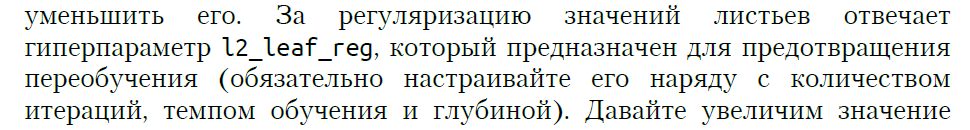

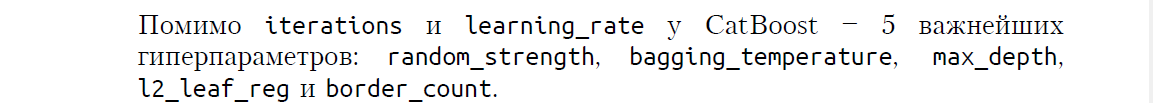

In [90]:
%%time

n_splits = 5
scores = []
models = []

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

for train_index, val_index in skf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    

    model = CatBoostClassifier(
                                random_seed=RANDOM_STATE,
                                loss_function='MultiClass',
                                eval_metric='TotalF1:average=Macro',
                                cat_features=categorical_features_indices,
                                thread_count=-1,
                                task_type='GPU',
    )

    model.fit(
                X_train, y_train,
                eval_set=(X_val, y_val),
                early_stopping_rounds=100,
                verbose=100
    )
    
    models.append(model)
    
    y_pred = model.predict(X_val)
    scores.append(f1_score(y_val, y_pred, average='macro'))

np.mean(scores)

Learning rate set to 0.142203
0:	learn: 0.1340483	test: 0.1342772	best: 0.1342772 (0)	total: 130ms	remaining: 2m 9s
100:	learn: 0.9781771	test: 0.9413099	best: 0.9416833 (99)	total: 7.97s	remaining: 1m 10s
200:	learn: 0.9962117	test: 0.9762375	best: 0.9762375 (199)	total: 15s	remaining: 59.6s
300:	learn: 0.9988800	test: 0.9853471	best: 0.9853471 (292)	total: 21.8s	remaining: 50.7s
400:	learn: 0.9998411	test: 0.9859492	best: 0.9859492 (356)	total: 28.9s	remaining: 43.2s
500:	learn: 1.0000000	test: 0.9880660	best: 0.9880660 (476)	total: 36s	remaining: 35.8s
600:	learn: 1.0000000	test: 0.9887557	best: 0.9891398 (554)	total: 43s	remaining: 28.6s
bestTest = 0.989139782
bestIteration = 554
Shrink model to first 555 iterations.
Learning rate set to 0.142203
0:	learn: 0.1344405	test: 0.1343528	best: 0.1343528 (0)	total: 85.2ms	remaining: 1m 25s
100:	learn: 0.9709038	test: 0.9475322	best: 0.9481675 (99)	total: 7.8s	remaining: 1m 9s
200:	learn: 0.9945698	test: 0.9829720	best: 0.9829720 (200)	tot

0.9926303003791611

In [91]:
models

In [98]:
for m in models:
    print(m.tree_count_)

555
610
539
732
474


In [99]:
for m in models:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 1000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 3, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage': 'GpuRam', 'fo

In [93]:
models[0].get_best_score()

{'learn': {'TotalF1:average=Macro': 1.0, 'MultiClass': 0.025747276806938252},
 'validation': {'TotalF1:average=Macro': 0.9891397819503858,
  'MultiClass': 0.04562492301429012}}

## Важность признаков

### Feature Importance

In [100]:
models[0].get_feature_importance(prettified=True)

,Feature Id,Importances
0,working_time_per_week,15.49
1,most_frequent_route_per_week,13.43
2,most_frequent_gate_per_week,13.41
3,entry_time,11.98
4,cnt_users_per_week,9.89
5,pass_cnt_per_day,9.62
6,cnt_days_per_week,5.45
7,working_time_per_day,4.50
8,most_frequent_gate_per_day,2.30
9,most_frequent_route_per_day,2.14


In [101]:
feature_importance = models[0].feature_importances_
sorted_idx = np.argsort(feature_importance)

In [105]:
# plt.figure(figsize=(15, 15))
# plt.barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx], color='skyblue')
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.title('Feature Importance in CatBoostClassifier')
# plt.grid(axis='x', linestyle='--', linewidth=0.7)

### SHAP values

## Отбор признаков

In [427]:
# создаем список имен признаков
feature_names = list(X_train.columns)

# создаем список категориальных признаков
cat_features = categorical_columns

# создаем обучающий и проверочный пулы
train_pool = Pool(X_train, 
                  y_train,
                  feature_names=feature_names, 
                  cat_features=cat_features)

test_pool = Pool(X_test, 
                 y_test, 
                 feature_names=feature_names, 
                 cat_features=cat_features)

In [428]:
 model = CatBoostClassifier(
                                random_seed=RANDOM_STATE,
                                loss_function='MultiClass',
                                eval_metric='TotalF1:average=Macro',
                                cat_features=categorical_features_indices,
                                thread_count=-1,
                                task_type='GPU',
    )

In [430]:
# пишем функцию отбора признаков на основе 
# рекурсивного удаления признаков
def catboost_select_features(
    algorithm: EFeaturesSelectionAlgorithm, 
    steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(
                    iterations=500,
                    max_depth=7,
                    random_seed=RANDOM_STATE,
                    loss_function='MultiClass',
                    eval_metric='TotalF1:average=Macro',
                    cat_features=categorical_features_indices,
                    thread_count=-1,
                    task_type='GPU'
    )
    summary = model.select_features(
        # обучающий пул
        train_pool,
        # проверочный пул
        eval_set=test_pool,
        # список признаков, участвующих в отборе
        features_for_select=list(range(train_pool.num_col())),
        # количество отбираемых признаков
        num_features_to_select=50,
        # количество итераций обучения модели, вычисляющей 
        # оценки важностей (чем больше, тем лучше качество)
        steps=steps,
        # алгоритм отбора
        algorithm=algorithm,
        # метод вычисления значений SHAP
        shap_calc_type=EShapCalcType.Regular,
        # обучаем модель с отобранными признаками
        train_final_model=True,
        # уровень детализации вывода
        logging_level='Silent',
        # отрисовка кривых обучения и валидации
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [431]:
%%time

# выполняем отбор признаков
shap_summary = catboost_select_features(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
    steps=5
)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['gate_id', 'gate_id_lag_1', 'day_of_month', 'day_of_week', 'time_of_day', 'is_month_start', 'is_month_end', 'entrance_gate_id', 'exit_gate_id', 'gate_id_lag_2', 'gate_id_lag_3', 'gate_id_3', 'gate_id_lag_4', 'gate_id_4', 'gate_id_5', 'repeat_gate_lt_5s', 'repeat_gate_btw_5_10s', 'repeat_gate_btw_10_15s', 'repeat_gate_btw_15_90s', 'repeat_gate_ge_90s', 'route', 'most_frequent_gate_per_day', 'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week', 'total_minutes', 'sec_btw_lag_1', 'pass_cnt_per_day', 'cnt_users_per_day', 'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week', 'entry_time', 'working_time_per_day', 'working_time_per_week', 'daily_workload_index', 'sec_btw_1', 'sec_btw_2', 'sec_btw_lag_3', 'sec_btw_3', 'sec_btw_lag_4', 'sec_btw_4', 'sec_btw_lag_5', 'sec_btw_5', 'cnt_repeat_gate_lt_5s', 'cnt_repeat_gate_btw_5_10s', 'cnt_repeat_gate_btw_10_15s', 'cnt_repeat_gate_btw_15_90s', 'cnt_repeat_gate_ge_90s', 'cumti

In [432]:
# печатаем отобранные признаки
selected_feat = shap_summary['selected_features_names']
print(selected_feat)

['gate_id', 'gate_id_lag_1', 'day_of_month', 'day_of_week', 'time_of_day', 'is_month_start', 'is_month_end', 'entrance_gate_id', 'exit_gate_id', 'gate_id_lag_2', 'gate_id_lag_3', 'gate_id_3', 'gate_id_lag_4', 'gate_id_4', 'gate_id_5', 'repeat_gate_lt_5s', 'repeat_gate_btw_5_10s', 'repeat_gate_btw_10_15s', 'repeat_gate_btw_15_90s', 'repeat_gate_ge_90s', 'route', 'most_frequent_gate_per_day', 'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week', 'total_minutes', 'sec_btw_lag_1', 'pass_cnt_per_day', 'cnt_users_per_day', 'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week', 'entry_time', 'working_time_per_day', 'working_time_per_week', 'daily_workload_index', 'sec_btw_1', 'sec_btw_2', 'sec_btw_lag_3', 'sec_btw_3', 'sec_btw_lag_4', 'sec_btw_4', 'sec_btw_lag_5', 'sec_btw_5', 'cnt_repeat_gate_lt_5s', 'cnt_repeat_gate_btw_5_10s', 'cnt_repeat_gate_btw_10_15s', 'cnt_repeat_gate_btw_15_90s', 'cnt_repeat_gate_ge_90s', 'cumtime_per_day']


In [433]:
# печатаем исключенные признаки
eliminated_feat = shap_summary['eliminated_features_names']
print(eliminated_feat)

['total_seconds', 'sec_btw_lag_2', 'cumtime_at_route_per_day', 'hour', 'probability_gate_id', 'daily_gate_pass_count', 'is_weekend', 'gate_id_1', 'gate_id_2', 'gate_id_lag_5']


In [434]:
# формируем набор отобранных признаков
fulldata = X[selected_feat]

In [435]:
# создаем список категориальных признаков
cat_features = fulldata.select_dtypes(include=['category']).columns.tolist()
cat_features

['gate_id',
 'gate_id_lag_1',
 'day_of_month',
 'day_of_week',
 'time_of_day',
 'is_month_start',
 'is_month_end',
 'entrance_gate_id',
 'exit_gate_id',
 'gate_id_lag_2',
 'gate_id_lag_3',
 'gate_id_3',
 'gate_id_lag_4',
 'gate_id_4',
 'gate_id_5',
 'repeat_gate_lt_5s',
 'repeat_gate_btw_5_10s',
 'repeat_gate_btw_10_15s',
 'repeat_gate_btw_15_90s',
 'repeat_gate_ge_90s',
 'route',
 'most_frequent_gate_per_day',
 'most_frequent_gate_per_week',
 'most_frequent_route_per_day',
 'most_frequent_route_per_week']

In [436]:
# создаем пул
fulldata_pool = Pool(fulldata, 
                     y,
                     cat_features=cat_features)

In [437]:
%%time

# создаем модель
model_full = CatBoostClassifier(
                    iterations=500,
                    max_depth=7,
                    random_seed=RANDOM_STATE,
                    loss_function='MultiClass',
                    thread_count=-1,
                    task_type='GPU',
                    logging_level='Silent')

# обучаем модель
model_full.fit(fulldata_pool);

CPU times: total: 4min 5s
Wall time: 2min 1s


## Итоговое предсказание лучшей модели

In [106]:
models

In [225]:
def make_prediction_dict(df_test, name_columns, model):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    result['pred_user_id'] = model.predict(X)
    result = result.groupby('user_word')['pred_user_id'].agg(lambda group: dict(group.value_counts())).to_dict()
    return result

In [239]:
def make_prediction(df_test, name_columns, model):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    result['pred_user_id'] = model.predict(X)
    # датафрейм: user_word; предсказанный user_id; количество предсказанных конкретных user_id для конкретной категории user_word
    temp_1 = result.groupby(['user_word', 'pred_user_id']).size().reset_index(name='count_pred_user_id_in_user_word')
    # датафрейм: user_word; количество user_word
    temp_2 = result['user_word'].value_counts().reset_index(name='count_user_word')
    # датафрейм: user_word; pred_user_id; count_pred_user_id_in_user_word; count_user_word
    result = temp_1.merge(temp_2, on='user_word', how='left')
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word
    result['confidence'] = result['count_pred_user_id_in_user_word'] / result['count_user_word']
    # сортируем данные по убыванию уверенности
    result = result.sort_values(by='confidence', ascending=False)

    # формируем итоговый датафрейм
    final = pd.DataFrame(columns=['user_word', 'preds'])
    # user_word, которые уже добавлены в final
    words = set()
    # user_id, которые уже добавлены в final
    ids = set()
    # добавляем в final предсказания по приоритету уверенности (result уже отсортирован)
    for _, row in result.iterrows():
        word, user_id = row['user_word'], row['pred_user_id']
        if word not in words and user_id not in ids and row['confidence'] > 0.05:
            final.loc[len(final)] = [word, user_id]
            words.add(word)
            ids.add(user_id)

    # категориям, насчет которых модель не уверена, проставляется -999
    for word in (set(result['user_word'].unique()) - set(final['user_word'])):
        final.loc[len(final)] = [word, -999]
    
    return final.sort_values(by='user_word')

In [438]:
df_test = df_test.rename(columns={'user_id': 'user_word'})

Вариант Ивана

In [241]:
# выбор ответа для конкретного user_word
def choosing_answer(votes):
    votes = sorted(votes.items(), key=lambda x: x[1], reverse=True)
    
    if len(votes) == 1:                 # если существует единственный вариант ответа
        return votes[0]                 # возвращаем ответ и число голосов
    if votes[0][1] == votes[1][1]:      # если первые два места равны
        return -999, 100                # ответ со 100% неопределен
    return votes[0]


# функция отбора голосов
def vote_processing(d):
    word_to_id = {}
    id_to_word = {}
    result = []

    for user_word, votes in d.items():
        user_id, num = choosing_answer(votes)           # получили ответ и количество голосов
        result.append(tuple([user_word, user_id, num]))

    # отсортируем список по уверенности в ответе
    result = sorted(result, key=lambda x: x[2], reverse=True)

    # проверим список на наличие дубликатов:
    for user_word, user_id, number_of_votes in result:
        # ситуация, когда ответ user_id неопознан или уже есть (и его приоритет ниже, так как список отсортирован по убыванию уверенности)
        if user_id == -999 or user_id in id_to_word:
            word_to_id[user_word] = -999
            continue
        word_to_id[user_word] = user_id
        id_to_word[user_id] = user_word

    # сохраним в требуемом формате
    df = pd.Series(word_to_id).to_frame().reset_index()
    df.columns = ['user_word', 'preds']
    df = df.groupby('user_word')['preds'].first().to_frame()
    return df

Сделаем предсказание

In [439]:
result_dct = make_prediction_dict(df_test, fulldata.columns, model_full)
result_dct

{'aucroc': {24: 27},
 'binary': {12: 181, 14: 29, 46: 17, 49: 5, 9: 4},
 'blue': {56: 5, 14: 3},
 'categorical': {14: 123, 12: 1},
 'coefficient': {3: 15, 22: 7, 1: 6, 14: 5, 39: 3, 26: 3, 17: 2},
 'collinear': {19: 30,
  33: 23,
  35: 21,
  55: 18,
  47: 17,
  54: 15,
  46: 13,
  32: 10,
  6: 9,
  50: 8,
  1: 6,
  12: 5,
  3: 4,
  39: 4,
  37: 3,
  11: 3},
 'distributed': {19: 22, 35: 17, 0: 13, 39: 10, 50: 10, 33: 8, 11: 1},
 'epsilon': {1: 194, 24: 13, 49: 13},
 'f1': {6: 327, 37: 129},
 'fit': {15: 25,
  3: 17,
  23: 17,
  11: 13,
  37: 10,
  17: 9,
  47: 9,
  0: 6,
  54: 6,
  35: 6,
  43: 6,
  1: 4,
  46: 3,
  18: 2,
  6: 1},
 'gini': {15: 115, 39: 12, 49: 6, 27: 4, 7: 2},
 'independent': {1: 52, 49: 40, 15: 33, 14: 25, 39: 15, 33: 6, 9: 4},
 'lasso': {46: 9, 56: 6, 23: 3, 25: 1, 39: 1},
 'linear': {17: 86, 18: 20, 3: 12, 33: 9, 0: 6, 50: 5, 32: 4},
 'logistic': {56: 3},
 'loss': {19: 115,
  53: 40,
  12: 38,
  35: 35,
  15: 21,
  55: 20,
  11: 19,
  50: 10,
  0: 10,
  46: 1},
 'm

In [440]:
vote_processing(result_dct)

,preds
user_word,
aucroc,24
binary,12
blue,56
categorical,14
coefficient,-999
collinear,-999
distributed,-999
epsilon,1
f1,6


In [441]:
result_cb = make_prediction(df_test, fulldata.columns, model_full)
result_cb

,user_word,preds
0,aucroc,24
8,binary,12
29,blue,-999
2,categorical,14
22,coefficient,22
27,collinear,47
23,distributed,0
5,epsilon,1
11,f1,6
28,fit,37


In [442]:
len(result_cb)

34

Сохраненим результаты

In [444]:
csv_buffer = io.StringIO()
result_cb.to_csv(csv_buffer, index=False)
with zipfile.ZipFile('../data/answer.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.writestr('answer.csv', csv_buffer.getvalue())

In [445]:
result_cb.to_csv('../data/submit_cb_v_03.csv', index=False)

# Сравнение ответов

In [446]:
right_answers = pd.read_csv(r'E:\projects\SHIFT\предыдущие_наработки\right_answers.csv')
res_ivan = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\1) 04_02_2024\answer_ivan.csv')
res_vera = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\4) Ivanova_Vera_SaintPetersburg 358\shift_ml-main\answer_vera.csv')
res_cb_01 = pd.read_csv('../data/submit_cb_v_01_264.csv')
res_cb_02 = pd.read_csv('../data/submit_cb_v_02.csv')
res_cb_03 = pd.read_csv('../data/submit_cb_v_03.csv')

In [447]:
res = right_answers.loc[:].rename(columns={'preds': 'right_answers'})
res['right_answers'] = res['right_answers'].apply(lambda x: f'{x:.0f}')
res['ivan'] = res_ivan['preds']
res['vera'] = res_vera['preds']
res['cb_v_01_264'] = res_cb_01['preds']
res['cb_v_02'] = res_cb_02['preds']
res['cb_v_03'] = res_cb_03['preds']

In [448]:
# Функция для условного форматирования
def highlight_matching_cells(x):
    ref_col = x['vera']
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for col in x.columns:
        if col == 'right_answers':
            df_styled[col] = ['background-color: red' if x[col].iloc[i] != 'nan' else '' for i in range(len(x))]
        elif col != 'vera':
            df_styled[col] = ['background-color: green' if x[col].iloc[i] == ref_col.iloc[i] else '' for i in range(len(x))]
    return df_styled

# Применение стиля
res.style.apply(highlight_matching_cells, axis=None)

,user_word,right_answers,ivan,vera,cb_v_01_264,cb_v_02,cb_v_03
0,aucroc,24,24,24,24,49,24
1,binary,12,12,12,12,12,12
2,blue,nan,-999,56,-999,-999,-999
3,categorical,14,14,14,14,14,14
4,coefficient,nan,-999,27,22,22,22
5,collinear,nan,-999,23,-999,-999,47
6,distributed,0,0,0,0,35,0
7,epsilon,1,1,1,1,1,1
8,f1,6,6,18,37,6,6
9,fit,nan,23,6,-999,23,37


# The end